In [ ]:

# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


In [ ]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [ ]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:
# Dimensionality of the latent space
latent_dim = 100

In [ ]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [ ]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [ ]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
# Train the GAN


# Config
batch_size = 32
epochs = 10000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)


  #######################
  ### Train generator ###
  #######################

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
epoch: 5101/10000, d_loss: 0.75,       d_acc: 0.44, g_loss: 0.76
1/1 [==============================] - 0s 25ms/step
epoch: 5201/10000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.74
1/1 [==============================] - 0s 23ms/step
epoch: 5301/10000, d_loss: 0.74,       d_acc: 0.41, g_loss: 0.76
1/1 [==============================] - 0s 36ms/step
epoch: 5401/10000, d_loss: 0.73,       d_acc: 0.42, g_loss: 0.72
1/1 [==============================] - 0s 25ms/step
epoch: 5501/10000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.78
1/1 [==============================] - 0s 31ms/step
epoch: 5601/10000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.75
1/1 [==============================] - 0s 38ms/step
epoch: 5701/10000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.77
1/1 [==============================] - 0s 24ms/step
epoch: 5801/10000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.77
1/1 [========

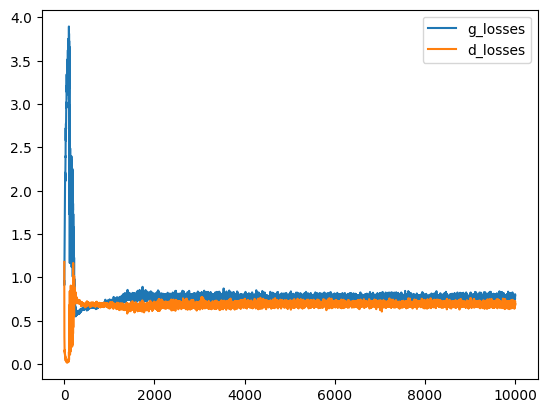

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

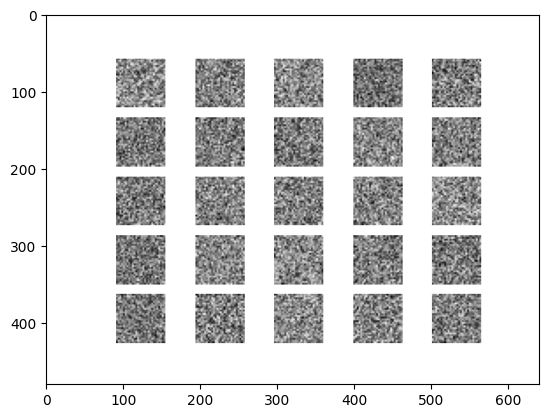

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

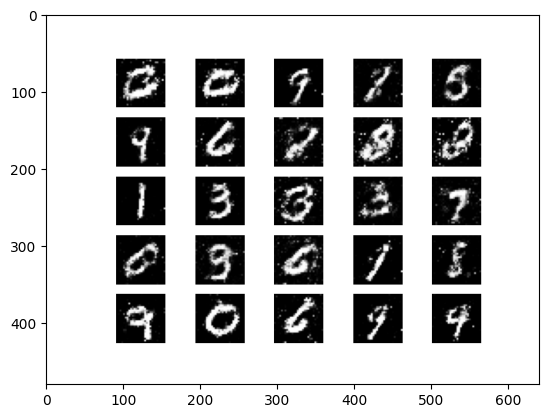

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

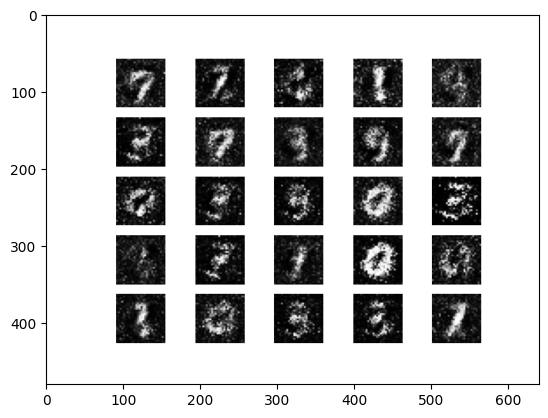

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

1/1 [==============================] - 0s 42ms/step


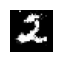

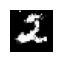

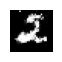

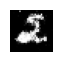

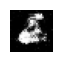

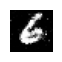

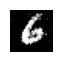

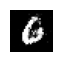

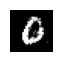

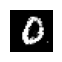

In [ ]:
# example of interpolating between generated digits
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
 # interpolate ratios between the points
 ratios = linspace(0, 1, num=n_steps)
 # linear interpolate vectors
 vectors = list()
 for ratio in ratios:
  v = (1.0 - ratio) * p1 + ratio * p2
  vectors.append(v)
 return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
  for i in range(n):
    pyplot.subplot(1, n, 1 + i)
 # turn off axis
    pyplot.axis('off')
 # plot raw pixel data
    plt.imshow(examples[i].reshape(H, W), cmap='gray')
    pyplot.show()


pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = generator.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

In [ ]:
pts

array([[-0.13471552,  0.19568256, -0.88037216, -0.85170025,  0.74675313,
         1.74889527,  2.0063046 , -0.72068168, -0.33335584,  0.76222688,
        -0.34677405, -1.13989522, -1.49198154,  1.84468935,  0.79944254,
        -2.62178923, -0.8010027 , -2.42934078, -0.73395227,  1.89611285,
        -0.58034186,  1.06005836,  0.66961899,  0.58700457,  0.6948321 ,
        -0.13372542,  0.52176592,  0.72949992, -0.52783068, -1.27482476,
        -0.72486612,  1.27182618, -1.34524244,  0.10316483,  0.03818364,
         1.17067345, -0.52306291, -1.47179491, -0.84348055,  0.20923694,
         0.39653585, -2.18491603, -0.61470189, -1.57552914, -1.31235308,
        -0.04896686,  0.64615717, -0.23147855,  0.33528313,  0.5307951 ,
        -0.63492071, -1.50790121,  0.08199627,  0.00682498,  1.26636562,
        -1.14841042,  0.06482444,  0.73994976,  0.51233555, -1.03347356,
         0.70390652,  1.64462232,  0.83892073,  0.72953992,  0.82072775,
        -1.45740295,  0.72881252, -0.65306387, -0.3

In [ ]:
interpolated.shape

(10, 100)